In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

In [2]:
username = "lavender"
project_name = (
    "new_random_temporal_deploy_monthly_performance"  #'9_years_monthly_performance'
)
metric_name = "eval/roc_auc"
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs(f"{username}/{project_name}")
summary_list = []
config_list = []
name_list = []
for run in runs:
    # run.summary are the output key/values like accuracy.
    # We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # run.config is the input metrics.
    # We remove special values that start with _.
    conf = nested_to_record(run.config, sep="/")
    config = {k: v for k, v in conf.items() if not k.startswith("_")}
    config_list.append(config)

    # run.name is the name of the run.
    name_list.append(run.name)

import pandas as pd

summary_df = pd.DataFrame.from_records(summary_list)
config_df = pd.DataFrame.from_records(config_list)
name_df = pd.DataFrame({"name": name_list})
data_df = pd.concat([name_df, config_df, summary_df], axis=1)

data_df.to_csv("data/9_years_monthly_eval.csv")

In [3]:
plot_df = data_df[["name", metric_name]]
plot_df["year"] = plot_df.apply(lambda r: str(r["name"]).split("-")[0], axis=1).astype(
    int
)
plot_df["month"] = plot_df.apply(lambda r: str(r["name"]).split("-")[1], axis=1).astype(
    int
)
plot_df

/tmp/ipykernel_36884/1468340559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['year'] = plot_df.apply(lambda r: str(r['name']).split('-')[0], axis=1).astype(int)
/tmp/ipykernel_36884/1468340559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['month'] = plot_df.apply(lambda r: str(r['name']).split('-')[1], axis=1).astype(int)


,name,eval/roc_auc,year,month
0,2022-3,0.786044,2022,3
1,2022-4,0.774583,2022,4
2,2022-2,0.800786,2022,2
3,2022-1,0.788683,2022,1
4,2021-11,0.783923,2021,11
...,...,...,...,...
107,2013-7,0.779832,2013,7
108,2013-2,0.779516,2013,2
109,2013-1,0.865304,2013,1
110,2013-4,0.799915,2013,4


In [4]:
# wandb seems to have download issue? 2020-7 shows NaN auc, but website shows 73.47
print(plot_df[plot_df.name == "2020-7"])
plot_df.loc[plot_df["name"] == "2020-7", [metric_name]] = 0.7347
print(plot_df[plot_df.name == "2020-7"])

      name  eval/roc_auc  year  month
23  2020-7           NaN  2020      7
      name  eval/roc_auc  year  month
23  2020-7        0.7347  2020      7


In [5]:
for month in range(1, 7):
    print(plot_df[plot_df.name == f"2020-{month}"])

      name  eval/roc_auc  year  month
26  2020-1      0.840461  2020      1
      name  eval/roc_auc  year  month
25  2020-2      0.820367  2020      2
      name  eval/roc_auc  year  month
24  2020-3      0.801784  2020      3
      name  eval/roc_auc  year  month
27  2020-4      0.847067  2020      4
      name  eval/roc_auc  year  month
20  2020-5      0.845632  2020      5
      name  eval/roc_auc  year  month
21  2020-6      0.871676  2020      6


In [6]:
plot_df = plot_df.sort_values(by=["year", "month"])
plot_df = plot_df[plot_df.year < 2022]

/gpfs/data/oermannlab/users/lavender/.conda/envs/ds_hf/lib/python3.8/site-packages/seaborn/categorical.py:3201: UserWarning: Setting `sharex=False` with `color=None` may cause different levels of the `x` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharex", "x"), UserWarning)


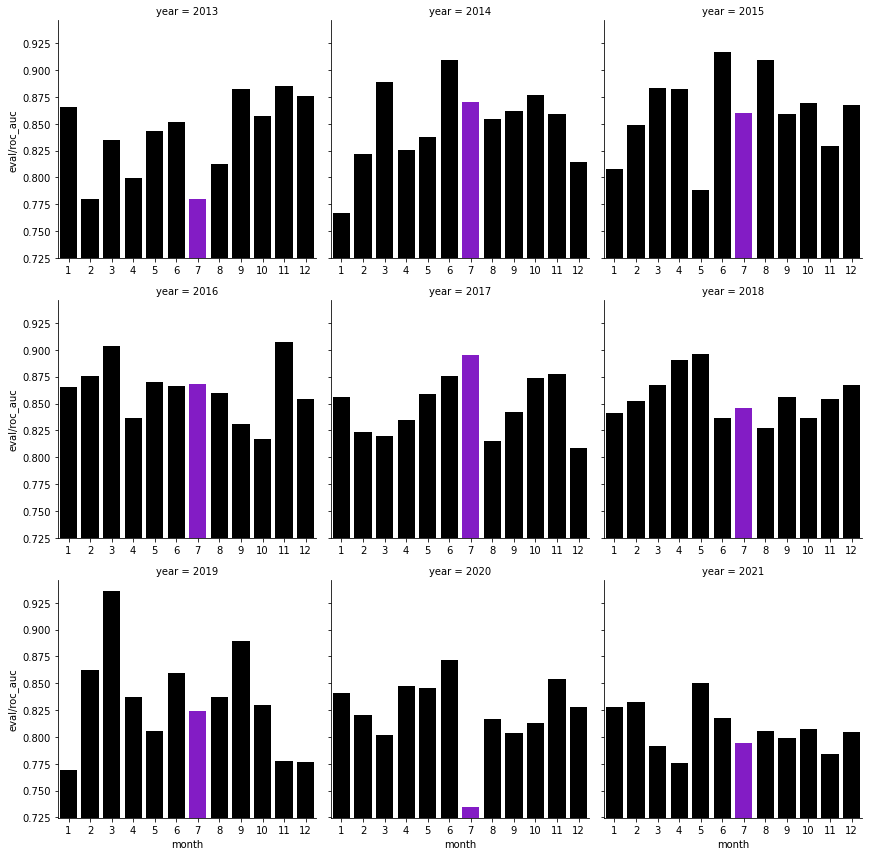

In [7]:
colors = ["#000000"] * 12
colors[6] = "#8900E1"
# Set your custom color palette
palette = sns.color_palette(colors)
sns.catplot(
    data=plot_df,
    x="month",
    y=metric_name,
    kind="bar",
    col="year",
    height=4,
    aspect=1,
    palette=palette,
    col_wrap=3,
    sharex=False,
)
plt.ylim([plot_df[metric_name].min() - 0.01, plot_df[metric_name].max() + 0.01])
plt.savefig("plots/9_years_monthly_perf.png", bbox_inches="tight", dpi=300)

In [8]:
month_avg = plot_df[["month", metric_name]].groupby("month").mean().reset_index()
month_avg.sort_values(by=metric_name)

,month,eval/roc_auc
0,1,0.826664
6,7,0.830278
11,12,0.833056
1,2,0.835286
3,4,0.836512
7,8,0.837522
9,10,0.842196
4,5,0.843945
8,9,0.847186
10,11,0.847650


In [9]:
month_var = plot_df[["month", metric_name]].groupby("month").var().reset_index()
month_var.sort_values(by=metric_name)

,month,eval/roc_auc
9,10,0.000762
1,2,0.000808
8,9,0.000993
5,6,0.001001
4,5,0.001034
7,8,0.001084
11,12,0.001200
3,4,0.001293
0,1,0.001429
10,11,0.001926


In [10]:
month_avg["count"] = [
    3936,
    3913,
    4105,
    3985,
    4003,
    10934,
    11265,
    11312,
    11003,
    11872,
    11100,
    11771,
]
month_avg["p"] = [
    0.10721544715447154,
    0.10605673396371071,
    0.10085261875761267,
    0.1026348808030113,
    0.11766175368473644,
    0.11578562282787636,
    0.1101642254771416,
    0.11156294200848656,
    0.10997000817958738,
    0.10773247978436658,
    0.10936936936936936,
    0.10559850479993203,
]
month_avg["readmission_rate"] = month_avg["p"].apply(lambda x: f"{100*x:10.2f}%")
month_avg["var"] = month_var[metric_name]
month_avg

,month,eval/roc_auc,count,p,readmission_rate,var
0,1,0.826664,3936,0.107215,10.72%,0.001429
1,2,0.835286,3913,0.106057,10.61%,0.000808
2,3,0.858601,4105,0.100853,10.09%,0.002427
3,4,0.836512,3985,0.102635,10.26%,0.001293
4,5,0.843945,4003,0.117662,11.77%,0.001034
5,6,0.867185,10934,0.115786,11.58%,0.001001
6,7,0.830278,11265,0.110164,11.02%,0.002672
7,8,0.837522,11312,0.111563,11.16%,0.001084
8,9,0.847186,11003,0.109970,11.00%,0.000993
9,10,0.842196,11872,0.107732,10.77%,0.000762


/tmp/ipykernel_36884/1942366696.py:8: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=plot_df, x='month',y=metric_name, palette = sns.color_palette("viridis", 12), dodge=True, alpha=0.7,


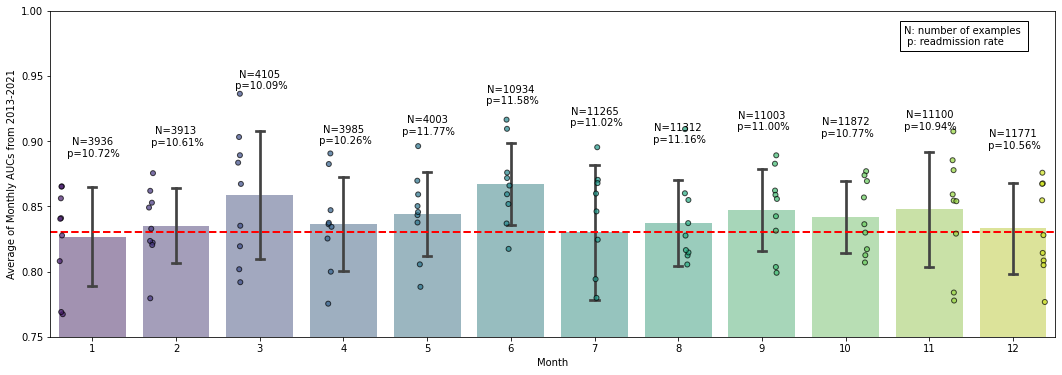

In [11]:
# note: we have fewer examples from jan to may because they all come from random test,
#      which is a 10% sample of the notes
#      examples from june to dec are larger in numbers because they come from temporal test
#      where the data is not further split
plt.figure(figsize=(18, 6))
ax = sns.barplot(
    data=plot_df,
    x="month",
    y=metric_name,
    alpha=0.5,
    palette=sns.color_palette("viridis", 12),
    errorbar="sd",
    capsize=0.1,
)
sns.stripplot(
    data=plot_df,
    x="month",
    y=metric_name,
    palette=sns.color_palette("viridis", 12),
    dodge=True,
    alpha=0.7,
    ax=ax,
    s=5,
    jitter=0.3,
    linewidth=1,
    edgecolor="black",
)
ax.axhline(0.830278, ls="--", color="red", linewidth=2)
t = plt.text(
    0.85,
    0.9,
    "N: number of examples \n p: readmission rate",
    wrap=True,
    transform=plt.gca().transAxes,
)
t.set_bbox(dict(facecolor="white", alpha=1, edgecolor="black"))
offsets = [0.03] * 12
offsets[2] += 0.01
offsets[6] += 0.01

for idx, p in enumerate(ax.patches):
    ax.annotate(
        "N="
        + str(month_avg.iloc[idx]["count"])
        + "\n p="
        + month_avg.iloc[idx]["readmission_rate"].strip(),
        (p.get_x() + 0.4, p.get_height() + 2 * offsets[idx]),
        ha="center",
        va="bottom",
        color="black",
    )
plt.ylim([0.75, 1])
plt.ylabel("Average of Monthly AUCs from 2013-2021")
plt.xlabel("Month")
plt.savefig("plots/new_monthly_perf_2013_2021.png", bbox_inches="tight", dpi=300)